In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from matplotlib import cm, colors
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
path = "../processed/evaluated/evaluated_448_03_03_2024.csv"
df = pd.read_csv(path)

In [3]:
z_threshold = 4.0
# Need to binary classify the results 

In [4]:
relevant_columns = ["id", "kgw-watermarked", "kgw-wm-zscore"]

In [5]:
base_wmark_df = df[relevant_columns].copy()
base_wmark_df["watermarked"] = [True for _ in range(len(base_wmark_df))]
base_wmark_df = base_wmark_df.rename(columns={"kgw-watermarked": "text", "kgw-wm-zscore": "z-score"})

non_wmark_df = df[["non-watermarked", "non-wm-zscore"]].copy()
non_wmark_df["watermarked"] = [False for _ in range(len(non_wmark_df))]
non_wmark_df = non_wmark_df.rename(columns={"non-watermarked": "text", "non-wm-zscore": "z-score"})

In [6]:
bc_df = pd.concat([base_wmark_df, non_wmark_df])
bc_df['watermark-detected'] = bc_df.apply(lambda x: x['z-score'] > z_threshold, axis=1)

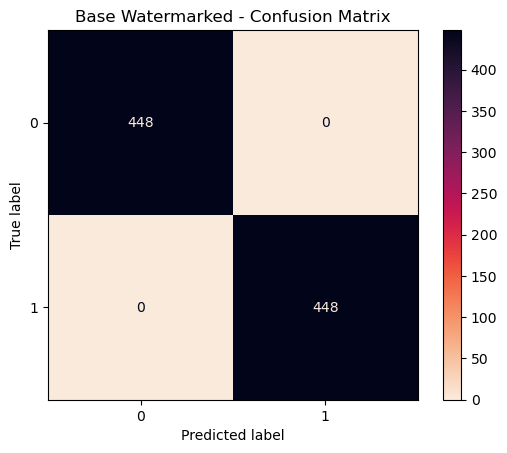

In [7]:
cf = confusion_matrix(bc_df["watermarked"], bc_df["watermark-detected"])
disp = ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot(cmap=sns.color_palette("rocket_r", as_cmap=True), colorbar=True)
plt.title(f"Base Watermarked - Confusion Matrix")
# plt.savefig(image_output_path+f"base_watermarked.png")
plt.show()

In [8]:
i = 1
pp_type = "sent"
relevant_columns = ["id", f"pp-kgw-{pp_type}-{i}", f"kgw-{pp_type}-zscore-{i}"]

In [9]:
para_scores_df = df[relevant_columns].copy()
para_scores_df["watermarked"] = [True for _ in range(para_scores_df.shape[0])]
para_scores_df = para_scores_df.rename(columns={f"pp-kgw-{pp_type}-{i}": "text", f"kgw-{pp_type}-zscore-{i}": "z-score"})

non_wmark_df = df[["non-watermarked", "non-wm-zscore"]].copy()
non_wmark_df["watermarked"] = [False for _ in range(len(non_wmark_df))]
non_wmark_df = non_wmark_df.rename(columns={"non-watermarked": "text", "non-wm-zscore": "z-score"})

In [10]:
bc_df = pd.concat([para_scores_df, non_wmark_df])
bc_df['watermark-detected'] = bc_df.apply(lambda x: x['z-score'] > z_threshold, axis=1)

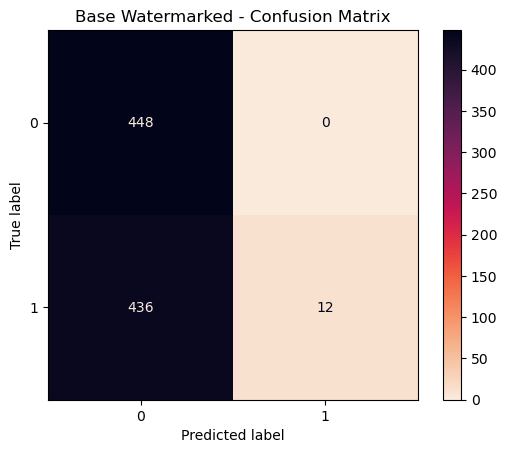

In [11]:
cf = confusion_matrix(bc_df["watermarked"], bc_df["watermark-detected"])
disp = ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot(cmap=sns.color_palette("rocket_r", as_cmap=True), colorbar=True)
plt.title(f"Base Watermarked - Confusion Matrix")
# plt.savefig(image_output_path+f"base_watermarked.png")
plt.show()

In [12]:
df.columns

Index(['id', 'instructions', 'text', 'kgw-watermarked', 'non-watermarked',
       'pp-kgw-para-1', 'pp-unwatermarked-para-1', 'pp-kgw-para-2',
       'pp-unwatermarked-para-2', 'pp-kgw-para-3', 'pp-unwatermarked-para-3',
       'pp-kgw-sent-1', 'pp-unwatermarked-sent-1', 'pp-kgw-sent-2',
       'pp-unwatermarked-sent-2', 'pp-kgw-sent-3', 'pp-unwatermarked-sent-3',
       'pp-kgw-word-1', 'pp-unwatermarked-word-1', 'pp-kgw-word-2',
       'pp-unwatermarked-word-2', 'pp-kgw-word-3', 'pp-unwatermarked-word-3',
       'pp-para-sim-1', 'pp-para-sim-2', 'pp-para-sim-3', 'pp-sent-sim-1',
       'pp-sent-sim-2', 'pp-sent-sim-3', 'kgw-wm-zscore', 'non-wm-zscore',
       'kgw-para-zscore-2', 'kgw-para-zscore-3', 'kgw-para-zscore-1',
       'nowm-para-zscore-2', 'nowm-para-zscore-3', 'nowm-para-zscore-1',
       'kgw-sent-zscore-2', 'kgw-sent-zscore-3', 'kgw-sent-zscore-1',
       'nowm-sent-zscore-2', 'nowm-sent-zscore-3', 'nowm-sent-zscore-1',
       'kgw-word-zscore-2', 'kgw-word-zscore-3', 'k

In [13]:
def make_base_marked_df(df, z_threshold = 4.0):
    col = "kgw-watermarked"
    zscore_col = "kgw-wm-zscore"

    bc_df = df[[col, zscore_col]].copy()

    bc_df["watermarked"] = np.full(bc_df.shape[0], True)
    bc_df["watermark-detected"] = bc_df[zscore_col] >= z_threshold
    return bc_df

In [33]:
def make_pp_marked_df(df, pp_type, pp_iter, z_threshold = 4.0):
    pp_col = f"pp-kgw-{pp_type}-{pp_iter}"
    pp_zscore = f"kgw-{pp_type}-zscore-{pp_iter}"

    bc_df = df[[pp_col, pp_zscore]].copy()

    bc_df["watermarked"] = np.full(bc_df.shape[0], True)
    bc_df["watermark-detected"] = bc_df[pp_zscore] >= z_threshold
    return bc_df

In [34]:
def plot_image(conf_matrix):
    ax = sns.heatmap(cosine_scores, annot=True, fmt='.3f', xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
    ax.set_ylabel("Text Group")
    ax.set_xlabel("Text Group")
    ax.set_title("Sentence Similarity between Recursive Paraphrases")
    
    if save:
        if save_location == None:
            raise "Save location must be defined if saving"
        plt.savefig(save_location)
    plt.show()

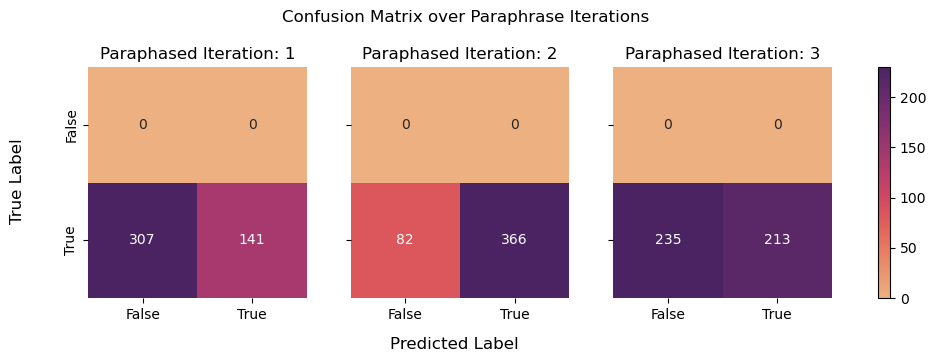

In [35]:
fig, axs = plt.subplots(1,3, figsize=(12, 3), sharey=True)
c_cmap = sns.color_palette("flare", as_cmap=True)
norm = colors.Normalize(vmin=0, vmax=230)

pp_type = "word"

for i in range(1,4):
    pp_bc_df = make_pp_marked_df(df, pp_type = pp_type, pp_iter=i)
    cf = confusion_matrix(pp_bc_df["watermarked"], pp_bc_df["watermark-detected"])
    hm = sns.heatmap(cf, annot=True, fmt=".0f",ax=axs[i-1], cmap=c_cmap, vmin=0, vmax=230, cbar=False, xticklabels=["False", "True"], yticklabels=["False", "True"])
    axs[i-1].set_title(f"Paraphased Iteration: {i}")

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=c_cmap), ax=axs.ravel().tolist())
fig.supxlabel("Predicted Label", x=0.43, y=-0.07)
fig.supylabel("True Label", x=0.06)
fig.suptitle("Confusion Matrix over Paraphrase Iterations", y=1.07, x=0.44)
# plt.savefig(image_output_path+f"combined_iterations.png", bbox_inches='tight')
plt.show()

## Making Table Stats

In [36]:
def get_rates(cf):
    tn, fp, fn, tp = cf.ravel()

    fpr = fp / (fp + tn)    
    tnr = tn / (tn + fp)
    
    tpr = tp / (fn + tp)
    fnr = fn / (fn + tn)
    
    return {"fpr": fpr, "tnr": tnr, "tpr": tpr, "fnr": fnr}

In [37]:
def get_ratings(y_true, y_pred):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            if y_true[i] == 0:
                tn += 1
            else:
                tp += 1
        elif y_true[i] != y_pred[i]:
            if y_pred[i] == 0:
                fn +=1 
            else:
                fp += 1
    
    return (tp, fp, tn, fn)

In [41]:
def find_scores(m_df):
    tp, fp, tn, fn = get_ratings(m_df["watermarked"].to_numpy(), 
                                 m_df["watermark-detected"].to_numpy())

    p = tp + fn
    n = tn + fp

    tnr = tn / n if n != 0 else 1.0
    fpr = fp / n if n != 0 else 0.0
        
    tpr = tp / p 
    fnr = fn / p
    
    print(f"FPR: {fpr:.3f} | TNR: {tnr:.3f} | TPR: {tpr:.3f} | FNR: {fnr:.3f}")

In [44]:
base_bc_df = make_base_marked_df(df)
find_scores(base_bc_df)

no_paraphrases = 3
for i in range(no_paraphrases):
    d_2 = make_pp_marked_df(df, pp_type="para", pp_iter=i+1)
    find_scores(d_2)

FPR: 0.000 | TNR: 1.000 | TPR: 1.000 | FNR: 0.000
FPR: 0.000 | TNR: 1.000 | TPR: 0.016 | FNR: 0.984
FPR: 0.000 | TNR: 1.000 | TPR: 0.203 | FNR: 0.797
FPR: 0.000 | TNR: 1.000 | TPR: 0.027 | FNR: 0.973
